In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
# from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os

## Load Data

In [7]:
labels = ["Opaque", "Red", "Green", "Yellow", "Bright", "Light-blue", "Colors", "Red", "Women", "Enemy", "Son", "Man", "Away", "Drawer", "Born", "Learn",
          "Call", "Skimmer", "Bitter", "Sweet milk", "Milk", "Water", "Food", "Argentina", "Uruguay", "Country", "Last name", "Where", "Mock", "Birthday", "Breakfast", "Photo",
          "Hungry", "Map", "Coin", "Music", "Ship", "None", "Name", "Patience", "Perfume", "Deaf", "Trap", "Rice", "Barbecue", "Candy", "Chewing-gum", "Spaghetti",
          "Yogurt", "Accept", "Thanks", "Shut down", "Appear", "To land", "Catch", "Help", "Dance", "Bathe", "Buy", "Copy", "Run", "Realize", "Give", "Find"]

data_dir = os.path.join(os.getcwd(), 'dataset', 'npz')
datasets = os.listdir(data_dir)
selected_frames = 12

In [8]:
X, y = [], []

for filename in datasets:
    content = np.load(os.path.join(data_dir, filename))
    length = content['x'].shape[0]
    if length < selected_frames:
        continue
    selected = content['y'][np.linspace(0, length-1, selected_frames).astype(int)]
    # x = [line.flatten() for line in selected]
    X.append(np.array(selected, dtype='float32'))
    y.append(int(filename.split('_')[0])-1)

X = np.array(X, dtype='float32')
y = np.array(y, dtype='uint8')
y = to_categorical(y).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [9]:
X_train.shape, y_train.shape

((2123, 12, 75, 3), (2123, 64))

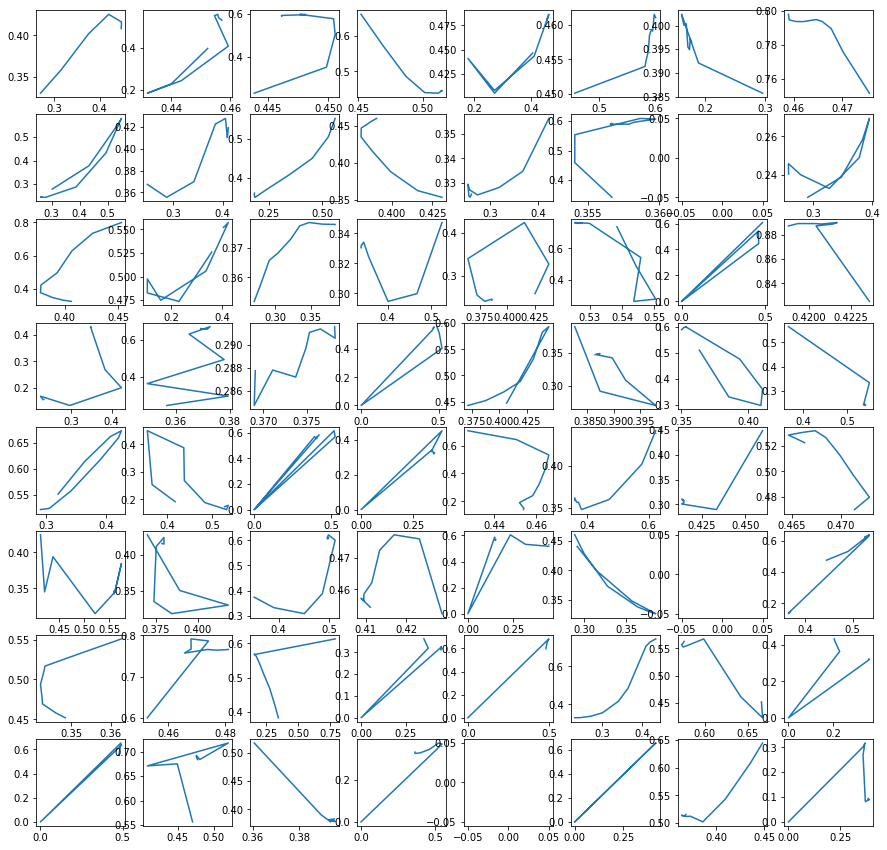

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
#矢量图,64个手势
def draw_vector(key):#key值-[0,74]代表不同的位点
    x,y=[],[]
    plt.figure(figsize=(15,15))
    for m in range(64):
        plt.subplot(8,8,m+1)
        for i in range(X_train.shape[0]):
            if y_train[i][m]==1:
                for j in range(X_train.shape[1]):
                    x.append(X_train[i][j][key][0])
                    y.append(X_train[i][j][key][1])
            if len(x)!=0:
                break
        plt.plot(x,y)
        x,y=[],[]
draw_vector(38)
# print(y)
# plt.figure(figsize=(3,3))
# plt.scatter(x,y,s=10)

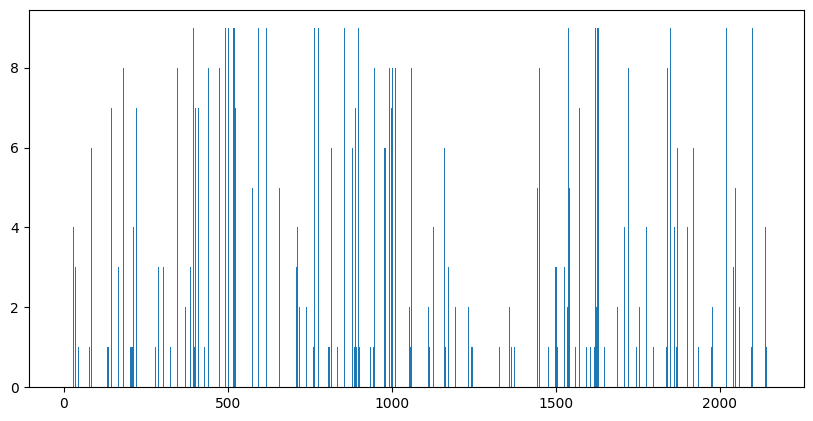

In [7]:
def data_set_feature(x):#x代表位点
    cnt,index=[],[]
    for i in range(X_train.shape[0]):
        tmp=0
        index.append(i)
        for k in range(X_train.shape[1]):
            #for m in range(X_train.shape[2])
            if X_train[i][k][x][0]!=0 and X_train[i][k][0][1]!=0:
                tmp+=1
        cnt.append(tmp)
    plt.figure(figsize=(10,5),dpi=100)
    plt.bar(index,cnt)
    #print(cnt)
data_set_feature(70)

In [6]:
log_dir = "./logs/"
callback = TensorBoard(log_dir)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Model

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
 
# softmax classifier
model.add(Dense(y_train.shape[1]))
model.add(Activation("softmax"))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
model.fit(X_train, y_train, epochs=40)

Epoch 1/40
67/67 [==============================] - 3s 34ms/step - loss: 4.4661 - accuracy: 0.0838
Epoch 2/40
67/67 [==============================] - 2s 34ms/step - loss: 2.9273 - accuracy: 0.2586
Epoch 3/40
67/67 [==============================] - 2s 33ms/step - loss: 2.2048 - accuracy: 0.3674
Epoch 4/40
67/67 [==============================] - 2s 34ms/step - loss: 1.8799 - accuracy: 0.4381
Epoch 5/40
67/67 [==============================] - 2s 34ms/step - loss: 1.6252 - accuracy: 0.5059
Epoch 6/40
67/67 [==============================] - 2s 34ms/step - loss: 1.3445 - accuracy: 0.6001
Epoch 7/40
67/67 [==============================] - 2s 34ms/step - loss: 1.1590 - accuracy: 0.6340
Epoch 8/40
67/67 [==============================] - 2s 34ms/step - loss: 1.0404 - accuracy: 0.6632
Epoch 9/40
67/67 [==============================] - 2s 34ms/step - loss: 0.9028 - accuracy: 0.6971
Epoch 10/40
67/67 [==============================] - 2s 35ms/step - loss: 0.8149 - accuracy: 0.7268
Epoch 11/

In [13]:
model.save("model/VGGNet12")

INFO:tensorflow:Assets written to: model/VGGNet12\assets


In [ ]:
model = keras.models.load_model("model/VGGNet-mini")

In [ ]:
model.fit(X_train, y_train, epochs=20)#, callbacks=[callback]

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
np.argmax(y_predict, axis=1)